In [1]:
import sys
sys.path.append('../../')

from amplify.client import FixstarsClient
import numpy as np
import os

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator import MeshDoublePipe
from optimizer import Annealing, AnnealingSolver, PolyTop
from problems.topo_opt_level_set_fluid_flow import TopologyOptimizationProblem

# Topology Optimization for Double Pipe Problem

## Computational Mesh

In [2]:
# Create Meshes for double pipe problem.
n_elem_for_width = 48
n_elem_for_height = 32
mesh_v = MeshDoublePipe('Q2', n_elem_for_width, n_elem_for_height, width=1.5, height=1.0, inlet_height=1./6., outlet_height=1./6.)
mesh_p = MeshDoublePipe('Q1', n_elem_for_width, n_elem_for_height, width=1.5, height=1.0, inlet_height=1./6., outlet_height=1./6.)

## Finite Element Model

### Boundary Conditions

In [3]:
def upper_inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 1-144*((y-3/4)**2); v_y = 0.0
    return np.array([v_x, v_y])

In [4]:
def lower_inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 1-144*((y-1/4)**2); v_y = 0.0
    return np.array([v_x,v_y])

In [5]:
# Compute boundary velocities.
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}
for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet_upper':
            boundary_velocity[boundary].append(upper_inlet_velocity(mesh_v, i_node))
        elif boundary == 'inlet_lower':
            boundary_velocity[boundary].append(lower_inlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))

# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        if boundary == 'inlet_upper' or boundary == 'inlet_lower' or boundary == 'wall' :
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
boundary_values_v = np.array(BC)

### Material Properties

In [6]:
viscosity = 1. 
density = 1.

# 
epsilon = 8.e-2

### Finite Element Model

In [7]:
fem = FEM(mesh_v, mesh_p, viscosity, density, epsilon)
fem.set_boudary_values_v(boundary_values_v)

Objective Function:0.0011023851361693896


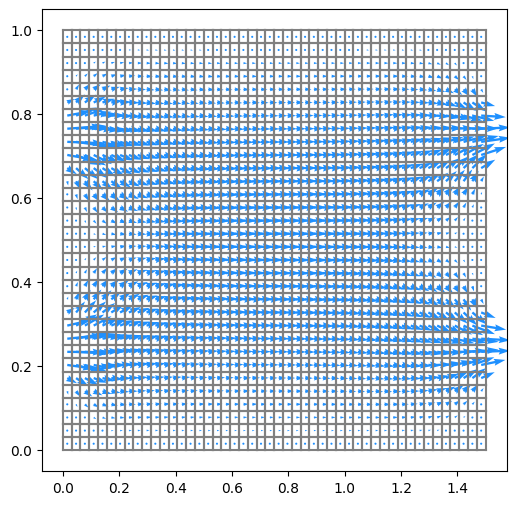

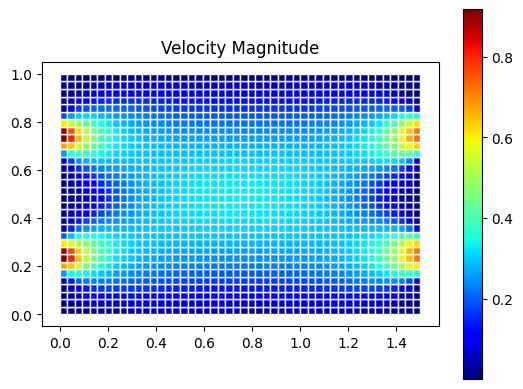

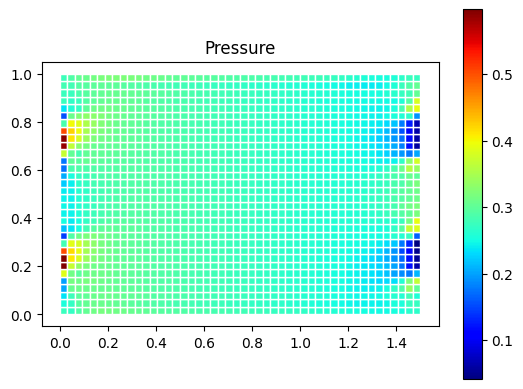

In [8]:
U, u_e, v_e, p_e, F, f=fem.solve()
print(f'Objective Function:{f}')
fem.plot_velocity_field([u_e, v_e])
fem.plot_velocity_magnitude([u_e, v_e])
fem.plot_pressure(p_e)

## Optimization

In [9]:
# Settings for Optimization.
volume_fraction_max = 1./3. # Volume fraction.
design_tolerance = 0.01 # Convergence tolerance on design variables.

active = {'classic': True,
          'annealing': True}

### Classical Optimization

In [10]:
density_initial = np.ones(mesh_v.n_elem) # Initial density, i.e., design variables, for each element.
density_min = 0.0; density_max = 1.0 # Lower and upper bound for design variables.

max_iterations = 150 # Max. number of optimization steps.

opt_OCMove = 0.2  # Allowable move step in OC update scheme
opt_OCEta = 0.5  # Exponent used in OC update scheme

q_values = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1] #

############## q = 1e-06 ###############
Iteration: 1, Objective Function: 0.0011023851361693896, Volume Fraction: 0.7999999999999999
Iteration: 2, Objective Function: 0.0011025498115766915, Volume Fraction: 0.6
Iteration: 3, Objective Function: 0.0011028242643492411, Volume Fraction: 0.4000000000000001
Iteration: 4, Objective Function: 0.00110337314650979, Volume Fraction: 0.20196043149420762
Iteration: 5, Objective Function: 0.0011048532187519298, Volume Fraction: 0.0917629328303256


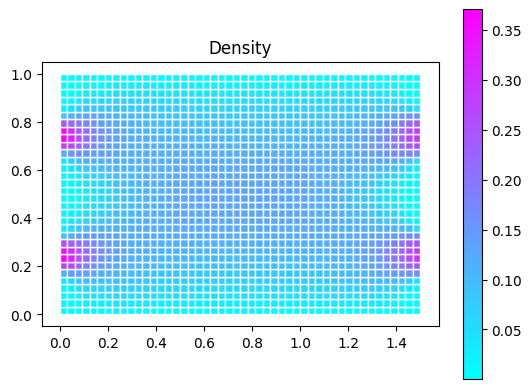

Iteration: 6, Objective Function: 0.001107067756935565, Volume Fraction: 0.09176111988524595


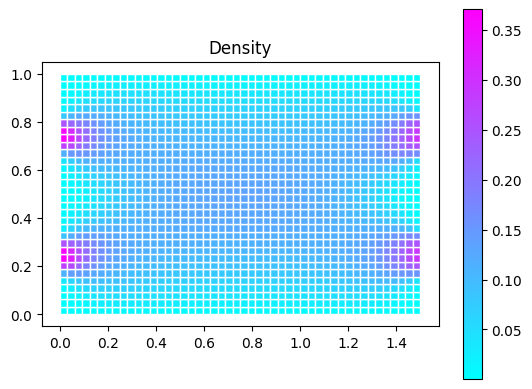

############## q = 1e-05 ###############
Iteration: 1, Objective Function: 0.00114919271062418, Volume Fraction: 0.24656433394704935
Iteration: 2, Objective Function: 0.0011162442299510406, Volume Fraction: 0.28471909875221474
Iteration: 3, Objective Function: 0.0011130995697531372, Volume Fraction: 0.2893526874920661
Iteration: 4, Objective Function: 0.0011127418548143929, Volume Fraction: 0.289713195880781
Iteration: 5, Objective Function: 0.0011127175173604937, Volume Fraction: 0.28971319720331673


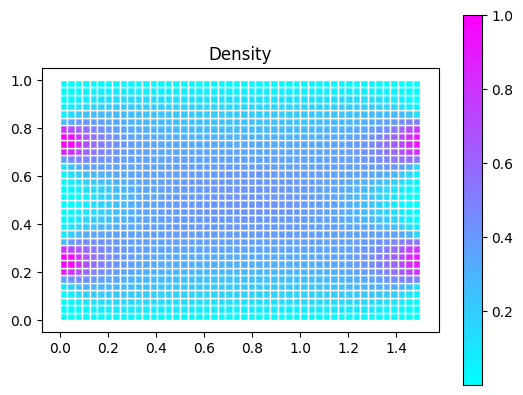

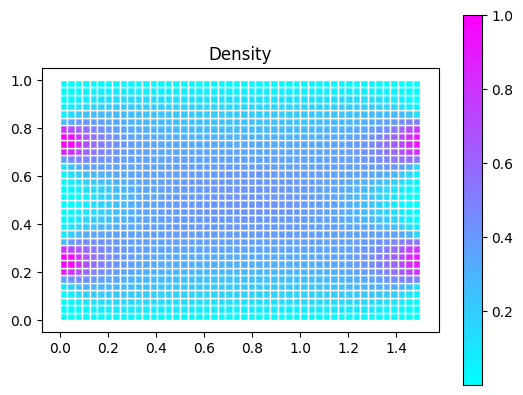

############## q = 0.0001 ##############
Iteration: 1, Objective Function: 0.0012054565305119238, Volume Fraction: 0.3446349841946959
Iteration: 2, Objective Function: 0.0011786915555384225, Volume Fraction: 0.3447167788111238


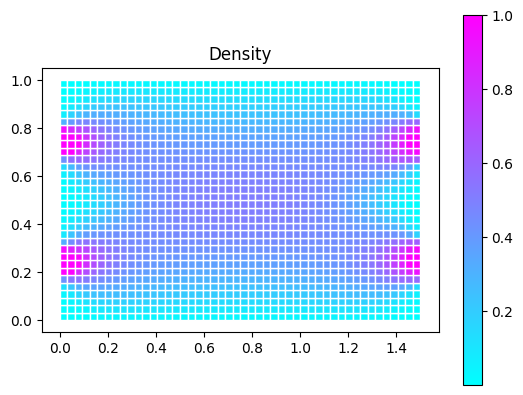

############## q = 0.001 ###############
Iteration: 1, Objective Function: 0.001849885509401855, Volume Fraction: 0.33126710896293604
Iteration: 2, Objective Function: 0.0018992263281774175, Volume Fraction: 0.3354870143906425
Iteration: 3, Objective Function: 0.0018784367460213682, Volume Fraction: 0.33123354043798414
Iteration: 4, Objective Function: 0.0018954251572271552, Volume Fraction: 0.331289638278624
Iteration: 5, Objective Function: 0.0018944181746776685, Volume Fraction: 0.3313836287463298


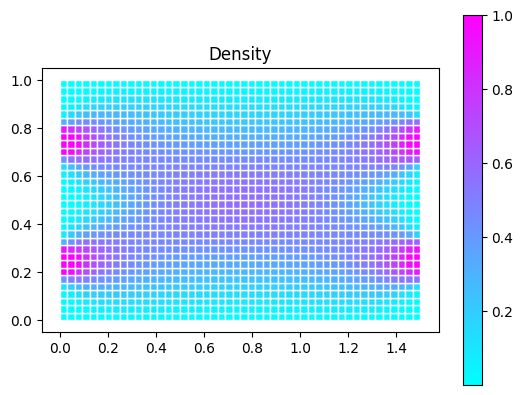

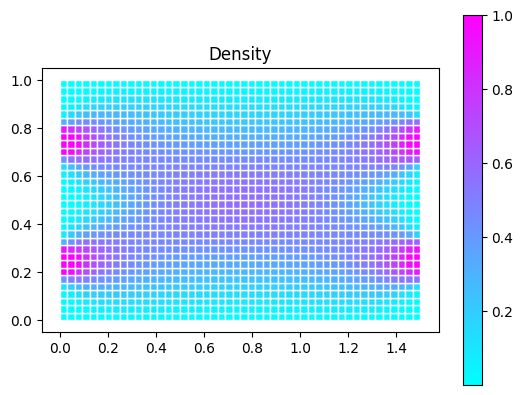

############### q = 0.01 ###############
Iteration: 1, Objective Function: 0.008156327490004008, Volume Fraction: 0.3334940337145607
Iteration: 2, Objective Function: 0.007640685107623729, Volume Fraction: 0.3333696832983879
Iteration: 3, Objective Function: 0.0072273919197425075, Volume Fraction: 0.33340016573584963
Iteration: 4, Objective Function: 0.006784652608920716, Volume Fraction: 0.33316908730221423
Iteration: 5, Objective Function: 0.006318145732464928, Volume Fraction: 0.3333537318718151


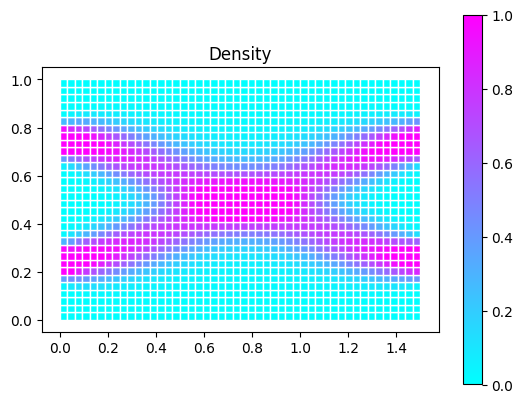

Iteration: 6, Objective Function: 0.005895052594904798, Volume Fraction: 0.3331793912987107
Iteration: 7, Objective Function: 0.005598428828918959, Volume Fraction: 0.3332349512436471
Iteration: 8, Objective Function: 0.005393361069548961, Volume Fraction: 0.3332931901005196
Iteration: 9, Objective Function: 0.005257062047305669, Volume Fraction: 0.33320630939814166
Iteration: 10, Objective Function: 0.005165710311050306, Volume Fraction: 0.333416727523677


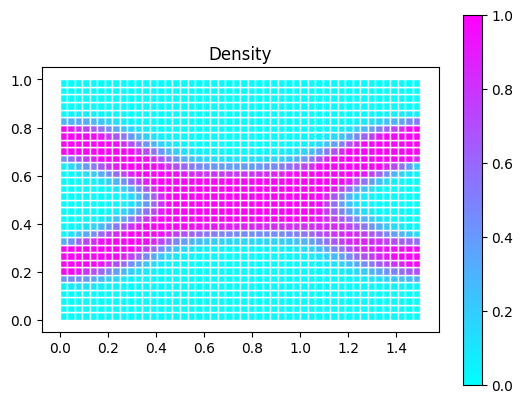

Iteration: 11, Objective Function: 0.005081725071482691, Volume Fraction: 0.33323629418890716
Iteration: 12, Objective Function: 0.0050146444635947775, Volume Fraction: 0.3332416089292247
Iteration: 13, Objective Function: 0.004935164838246325, Volume Fraction: 0.3334230674088577
Iteration: 14, Objective Function: 0.0048394918994324725, Volume Fraction: 0.33327795797147003
Iteration: 15, Objective Function: 0.004743551699647156, Volume Fraction: 0.33326860138081693


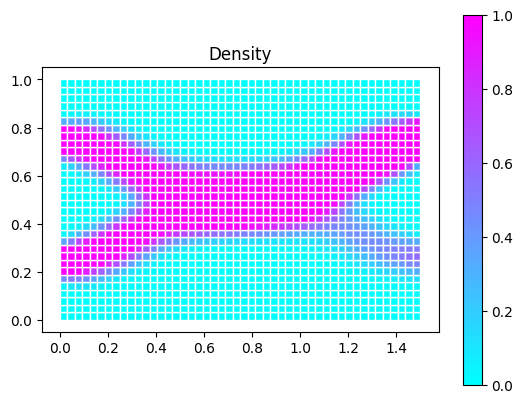

Iteration: 16, Objective Function: 0.004639200011493421, Volume Fraction: 0.33322776783907887
Iteration: 17, Objective Function: 0.004539898106336643, Volume Fraction: 0.3333888959535072
Iteration: 18, Objective Function: 0.004448906647128552, Volume Fraction: 0.3333689200295389
Iteration: 19, Objective Function: 0.004379999633885396, Volume Fraction: 0.33323548133342334
Iteration: 20, Objective Function: 0.004330291836487013, Volume Fraction: 0.33340103350313943


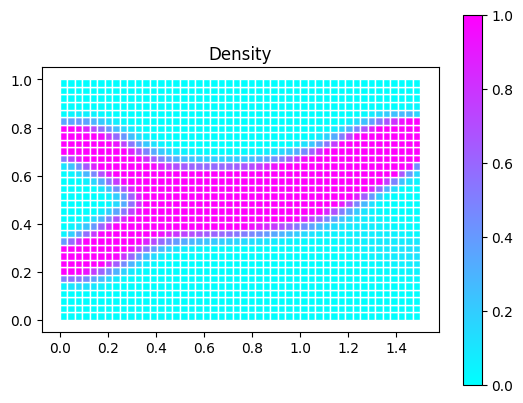

Iteration: 21, Objective Function: 0.004286737884543842, Volume Fraction: 0.33339959070654296
Iteration: 22, Objective Function: 0.004257627271864262, Volume Fraction: 0.3334210904634436
Iteration: 23, Objective Function: 0.004235068496454972, Volume Fraction: 0.3332921248002314
Iteration: 24, Objective Function: 0.004221405545785137, Volume Fraction: 0.3333951816504359
Iteration: 25, Objective Function: 0.00420595387647021, Volume Fraction: 0.3333061844866371


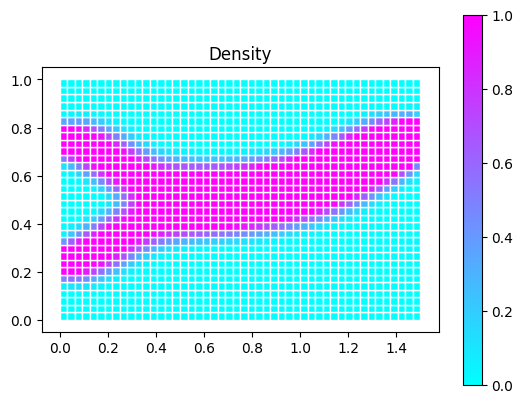

Iteration: 26, Objective Function: 0.004197502059285595, Volume Fraction: 0.3333487433560125
Iteration: 27, Objective Function: 0.00418703917979357, Volume Fraction: 0.33326174891158017
Iteration: 28, Objective Function: 0.004180326141480964, Volume Fraction: 0.33338462401776375
Iteration: 29, Objective Function: 0.004169569588665554, Volume Fraction: 0.33337047459488334
Iteration: 30, Objective Function: 0.004163248982888005, Volume Fraction: 0.33329444042257744


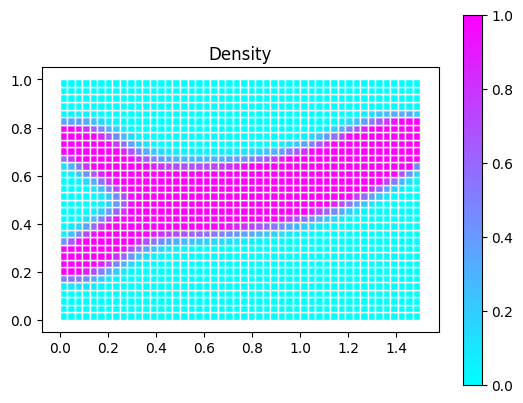

Iteration: 31, Objective Function: 0.004159310503159137, Volume Fraction: 0.33338819617914245
Iteration: 32, Objective Function: 0.004151922946735464, Volume Fraction: 0.3333210418660206
Iteration: 33, Objective Function: 0.004148814416477864, Volume Fraction: 0.33343393468078
Iteration: 34, Objective Function: 0.004142043820864881, Volume Fraction: 0.3333687673929376
Iteration: 35, Objective Function: 0.0041399657289193795, Volume Fraction: 0.3332492095015384


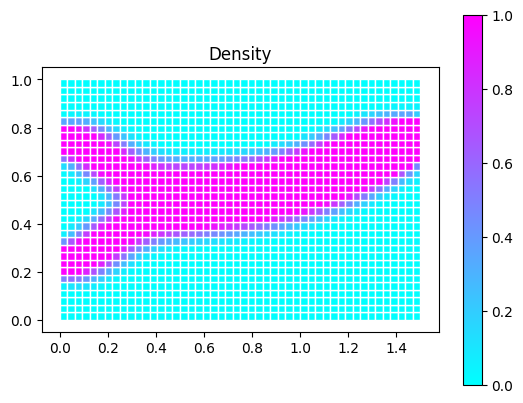

Iteration: 36, Objective Function: 0.004139183590576176, Volume Fraction: 0.3333435267653215
Iteration: 37, Objective Function: 0.0041331104453989995, Volume Fraction: 0.33332177091154663
Iteration: 38, Objective Function: 0.0041296861597227355, Volume Fraction: 0.33328665347153147
Iteration: 39, Objective Function: 0.004126887679088942, Volume Fraction: 0.3332330286363568
Iteration: 40, Objective Function: 0.004125107629799963, Volume Fraction: 0.3333849692257056


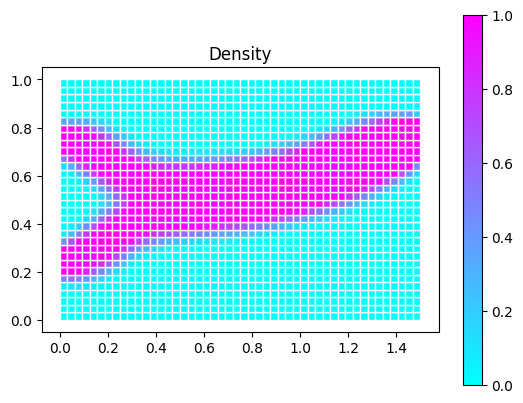

Iteration: 41, Objective Function: 0.0041190228397554995, Volume Fraction: 0.33337301058838326
Iteration: 42, Objective Function: 0.004116939042042256, Volume Fraction: 0.33330159692643896
Iteration: 43, Objective Function: 0.004115986697749832, Volume Fraction: 0.33322452404655883
Iteration: 44, Objective Function: 0.004114733747740654, Volume Fraction: 0.33340551316416
Iteration: 45, Objective Function: 0.004107339801035177, Volume Fraction: 0.33324061400599625


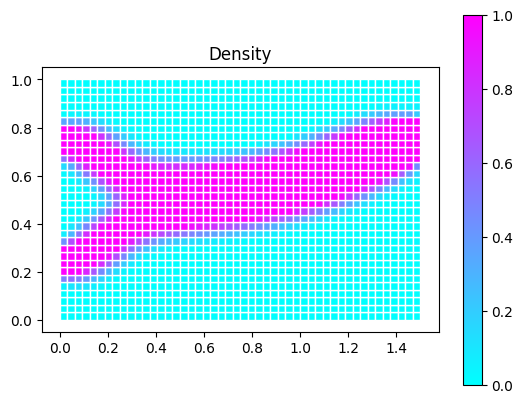

Iteration: 46, Objective Function: 0.004108211335942326, Volume Fraction: 0.3334172837314737
Iteration: 47, Objective Function: 0.004101424407187173, Volume Fraction: 0.3332349124973055
Iteration: 48, Objective Function: 0.004103456085267503, Volume Fraction: 0.3333826838096261
Iteration: 49, Objective Function: 0.004098119510768003, Volume Fraction: 0.33337840611512193
Iteration: 50, Objective Function: 0.004096350996996637, Volume Fraction: 0.33332284596966527


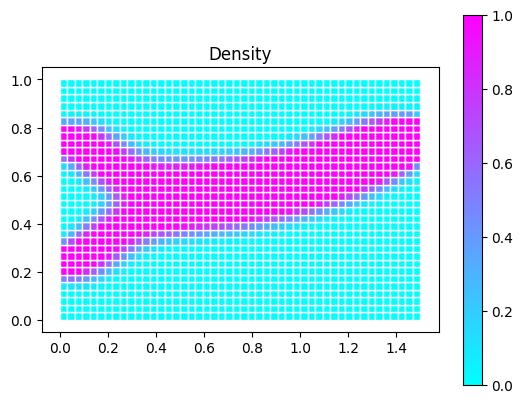

Iteration: 51, Objective Function: 0.004095833775272045, Volume Fraction: 0.33325157658978904
Iteration: 52, Objective Function: 0.004095967148579865, Volume Fraction: 0.33339196691944867
Iteration: 53, Objective Function: 0.0040914483889583535, Volume Fraction: 0.33338938789216294
Iteration: 54, Objective Function: 0.004090310487390513, Volume Fraction: 0.33334175191538323
Iteration: 55, Objective Function: 0.004090172167508151, Volume Fraction: 0.33327720055999105


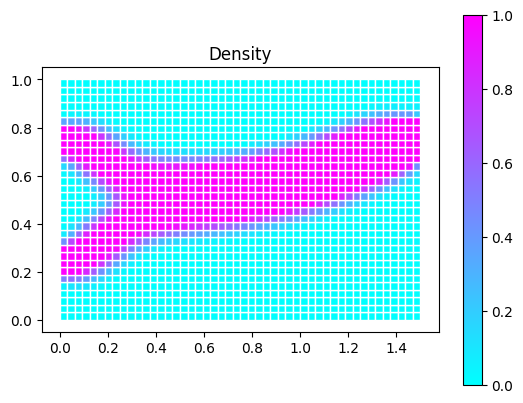

Iteration: 56, Objective Function: 0.0040902428233624746, Volume Fraction: 0.3334452485306371
Iteration: 57, Objective Function: 0.004084571741790712, Volume Fraction: 0.3332711676579671
Iteration: 58, Objective Function: 0.00408662033499175, Volume Fraction: 0.33342930212901595
Iteration: 59, Objective Function: 0.004081343279523626, Volume Fraction: 0.3332452696570025
Iteration: 60, Objective Function: 0.004084259181724229, Volume Fraction: 0.3333838204057001


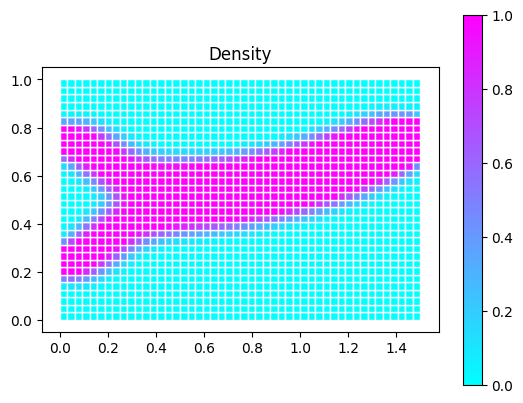

Iteration: 61, Objective Function: 0.004079713273939426, Volume Fraction: 0.33340389255264896
Iteration: 62, Objective Function: 0.004077892693817626, Volume Fraction: 0.33339272030927125
Iteration: 63, Objective Function: 0.004076909043577478, Volume Fraction: 0.33336890254677565
Iteration: 64, Objective Function: 0.004076275438522686, Volume Fraction: 0.33334045388029215
Iteration: 65, Objective Function: 0.004075897692369277, Volume Fraction: 0.3333073278625682


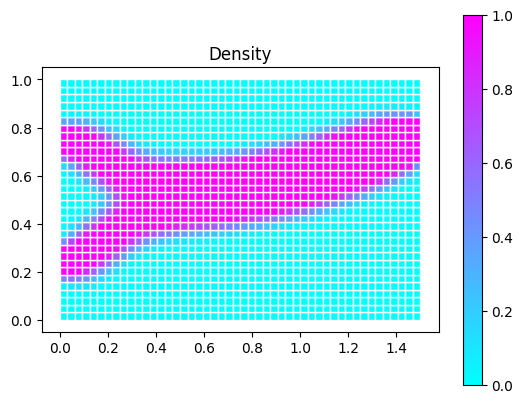

Iteration: 66, Objective Function: 0.00407588287908968, Volume Fraction: 0.3332514739858809
Iteration: 67, Objective Function: 0.004076561958323552, Volume Fraction: 0.3334034202492817
Iteration: 68, Objective Function: 0.0040725126548751, Volume Fraction: 0.33341041850580905


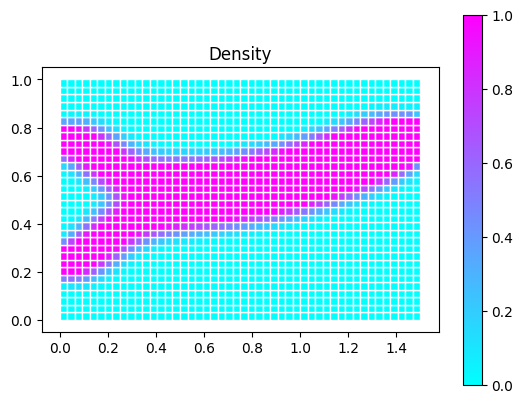

############### q = 0.1 ################
Iteration: 1, Objective Function: 0.006525041830021572, Volume Fraction: 0.33332224748015177
Iteration: 2, Objective Function: 0.005740937288415871, Volume Fraction: 0.3333218445880131
Iteration: 3, Objective Function: 0.0055883325230151265, Volume Fraction: 0.33333840749395915
Iteration: 4, Objective Function: 0.005549960628659172, Volume Fraction: 0.3333144075433326
Iteration: 5, Objective Function: 0.005535297105414976, Volume Fraction: 0.33331886635510694


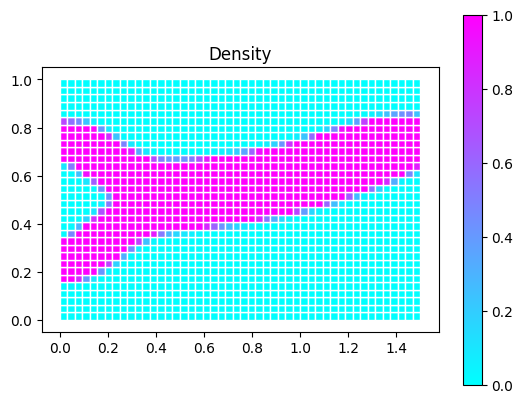

Iteration: 6, Objective Function: 0.005526469019776374, Volume Fraction: 0.33333819897157774
Iteration: 7, Objective Function: 0.005520013000155832, Volume Fraction: 0.3333371640870019
Iteration: 8, Objective Function: 0.005515953105700108, Volume Fraction: 0.3333494524135145
Iteration: 9, Objective Function: 0.005512173372442528, Volume Fraction: 0.3333233489864645
Iteration: 10, Objective Function: 0.0055104858244127575, Volume Fraction: 0.33333703728663827


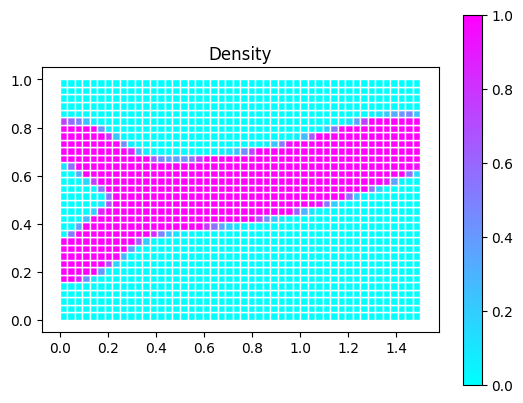

Iteration: 11, Objective Function: 0.005507431668709687, Volume Fraction: 0.3333517999398932
Iteration: 12, Objective Function: 0.005504536777794375, Volume Fraction: 0.3333278220180581
Iteration: 13, Objective Function: 0.005503364200478411, Volume Fraction: 0.33331716641907927
Iteration: 14, Objective Function: 0.005501691369324338, Volume Fraction: 0.33333834878075624
Iteration: 15, Objective Function: 0.005498859529520293, Volume Fraction: 0.33333512994212855


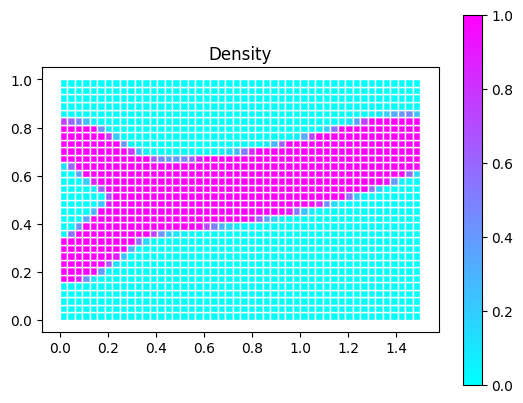

Iteration: 16, Objective Function: 0.005497155110500314, Volume Fraction: 0.3333231737845271
Iteration: 17, Objective Function: 0.005495880204345688, Volume Fraction: 0.333351904101816
Iteration: 18, Objective Function: 0.005492942141879923, Volume Fraction: 0.3333398107443785
Iteration: 19, Objective Function: 0.005491719700826689, Volume Fraction: 0.3333214340882393
Iteration: 20, Objective Function: 0.0054908209887869685, Volume Fraction: 0.3333468440549989


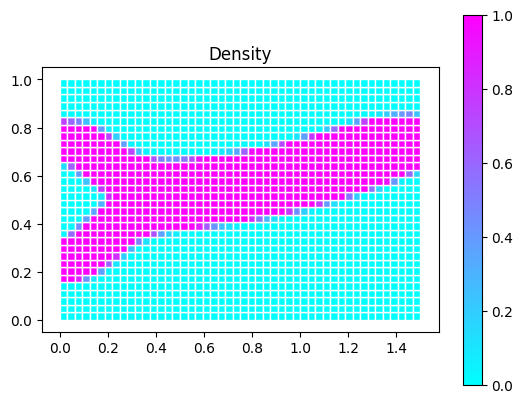

Iteration: 21, Objective Function: 0.005488116248154478, Volume Fraction: 0.33333027386780306
Iteration: 22, Objective Function: 0.005487151489181843, Volume Fraction: 0.3333150118473074
Iteration: 23, Objective Function: 0.005486159551649992, Volume Fraction: 0.33334281718143505
Iteration: 24, Objective Function: 0.005483407071661547, Volume Fraction: 0.33333147059104323
Iteration: 25, Objective Function: 0.005482320012130153, Volume Fraction: 0.333325550890111


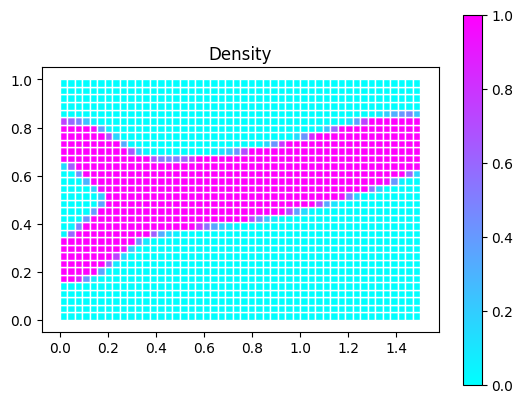

Iteration: 26, Objective Function: 0.005481060554920968, Volume Fraction: 0.3333383063088917
Iteration: 27, Objective Function: 0.005479186463957755, Volume Fraction: 0.3333240580506392
Iteration: 28, Objective Function: 0.005478592480454444, Volume Fraction: 0.3333308183930717
Iteration: 29, Objective Function: 0.00547724329578457, Volume Fraction: 0.33332509968778035
Iteration: 30, Objective Function: 0.005476469376325977, Volume Fraction: 0.33331662150620905


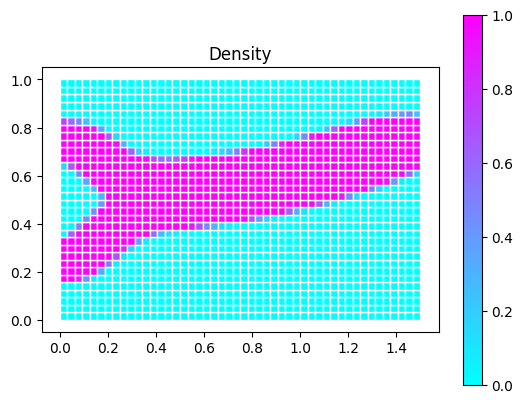

Iteration: 31, Objective Function: 0.005475833319943784, Volume Fraction: 0.3333477458506362
Iteration: 32, Objective Function: 0.005473546745975069, Volume Fraction: 0.33333371502339476
Iteration: 33, Objective Function: 0.005473096477318486, Volume Fraction: 0.33333532666278404
Iteration: 34, Objective Function: 0.005471935478350122, Volume Fraction: 0.33333261465179775
Iteration: 35, Objective Function: 0.005470928381633348, Volume Fraction: 0.33333339046438115


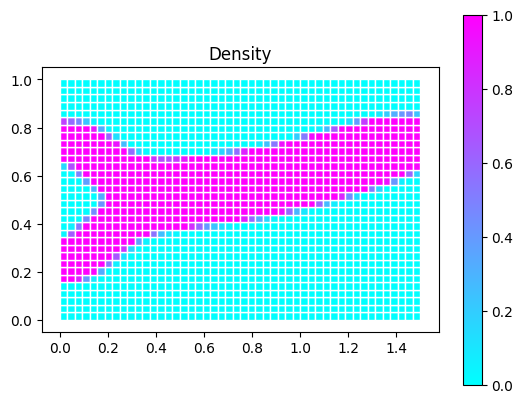

Iteration: 36, Objective Function: 0.005469734963510882, Volume Fraction: 0.33334500312039267
Iteration: 37, Objective Function: 0.005468028544198014, Volume Fraction: 0.3333254406569895
Iteration: 38, Objective Function: 0.005467531453150336, Volume Fraction: 0.3333157312742335
Iteration: 39, Objective Function: 0.005466492960077406, Volume Fraction: 0.3333421618120562
Iteration: 40, Objective Function: 0.005463867422071259, Volume Fraction: 0.33331944782110223


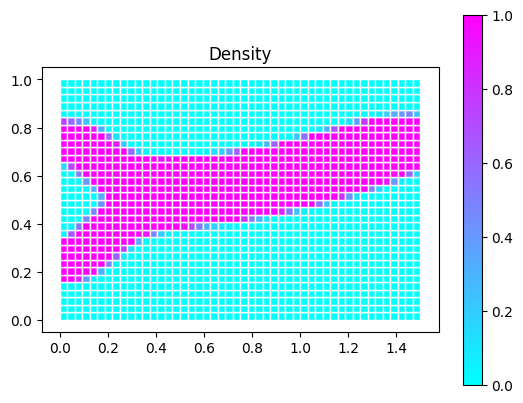

Iteration: 41, Objective Function: 0.005463172599194003, Volume Fraction: 0.33334445691326037
Iteration: 42, Objective Function: 0.005460553536520258, Volume Fraction: 0.3333189437927106
Iteration: 43, Objective Function: 0.005460402704037426, Volume Fraction: 0.33334358102683287
Iteration: 44, Objective Function: 0.005458446028241139, Volume Fraction: 0.3333286087336386
Iteration: 45, Objective Function: 0.005458207021282636, Volume Fraction: 0.333330674845881


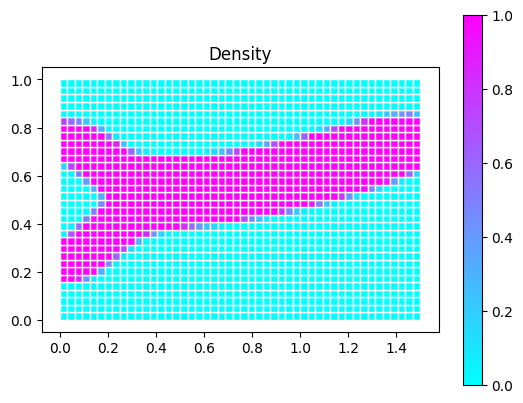

Iteration: 46, Objective Function: 0.005457349826410984, Volume Fraction: 0.33334846388698175
Iteration: 47, Objective Function: 0.005455925379323258, Volume Fraction: 0.3333393579762478
Iteration: 48, Objective Function: 0.0054556584825890915, Volume Fraction: 0.3333523088500781
Iteration: 49, Objective Function: 0.005454549076174596, Volume Fraction: 0.33334010577947937
Iteration: 50, Objective Function: 0.005454504945344396, Volume Fraction: 0.3333503926044661


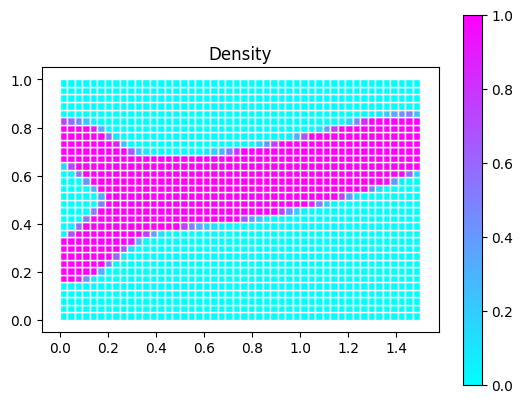

Iteration: 51, Objective Function: 0.005453585075230161, Volume Fraction: 0.3333390041607873
Iteration: 52, Objective Function: 0.0054535738798952805, Volume Fraction: 0.33331374255713836
Iteration: 53, Objective Function: 0.005454148704919486, Volume Fraction: 0.3333186593491955
Iteration: 54, Objective Function: 0.005453527547919365, Volume Fraction: 0.3333464014531425
Iteration: 55, Objective Function: 0.0054520082689765385, Volume Fraction: 0.33331375026182203


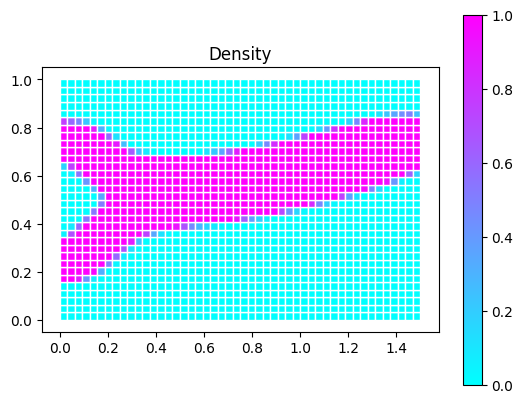

Iteration: 56, Objective Function: 0.005452936998525918, Volume Fraction: 0.33331858172331513
Iteration: 57, Objective Function: 0.005452365797988138, Volume Fraction: 0.3333507822985986
Iteration: 58, Objective Function: 0.00545070109384805, Volume Fraction: 0.3333255406140393
Iteration: 59, Objective Function: 0.005451344795358414, Volume Fraction: 0.3333405066158625
Iteration: 60, Objective Function: 0.0054503683705911955, Volume Fraction: 0.33334529282703


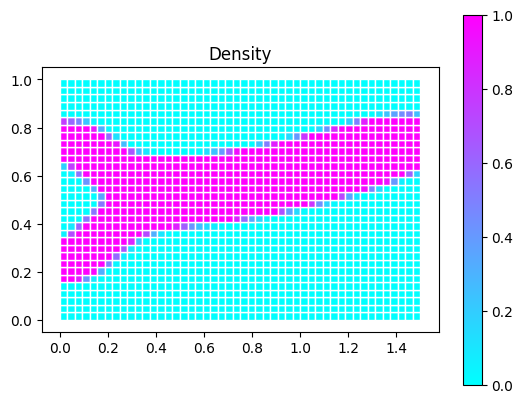

Iteration: 61, Objective Function: 0.0054497921611558935, Volume Fraction: 0.33334496943751163
Iteration: 62, Objective Function: 0.005449408833902963, Volume Fraction: 0.3333426354496518
Iteration: 63, Objective Function: 0.005449091480427186, Volume Fraction: 0.33334044893042974
Iteration: 64, Objective Function: 0.005448751265810717, Volume Fraction: 0.3333391811245134
Iteration: 65, Objective Function: 0.005448354393912216, Volume Fraction: 0.3333345603115149


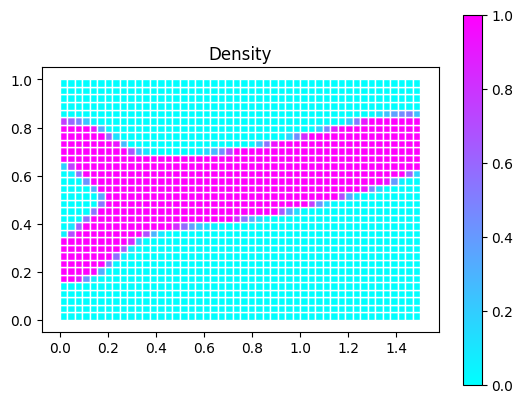

Iteration: 66, Objective Function: 0.00544807206850952, Volume Fraction: 0.33332568497549037
Iteration: 67, Objective Function: 0.00544794931450204, Volume Fraction: 0.333317934534115
Iteration: 68, Objective Function: 0.005447775446034067, Volume Fraction: 0.33335214579466127
Iteration: 69, Objective Function: 0.005445924412007634, Volume Fraction: 0.3333383661479785
Iteration: 70, Objective Function: 0.005446014110591771, Volume Fraction: 0.33333183562142693


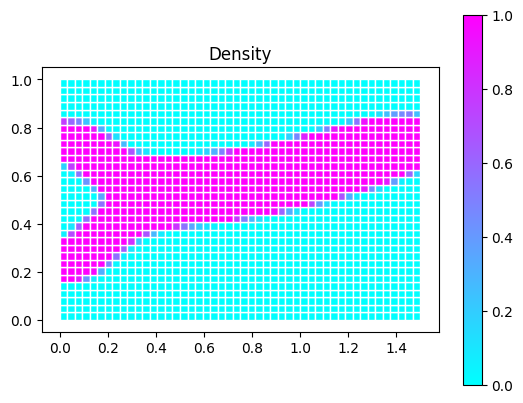

Iteration: 71, Objective Function: 0.005445838599144706, Volume Fraction: 0.33333020048579465
Iteration: 72, Objective Function: 0.005445494474068998, Volume Fraction: 0.333324516661986
Iteration: 73, Objective Function: 0.0054453486399089705, Volume Fraction: 0.33331854984533993
Iteration: 74, Objective Function: 0.005445246152369706, Volume Fraction: 0.33335176486049284
Iteration: 75, Objective Function: 0.005443597721934239, Volume Fraction: 0.3333322422594035


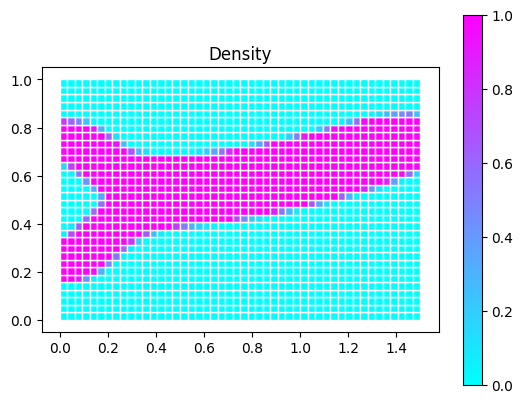

Iteration: 76, Objective Function: 0.0054440784269057345, Volume Fraction: 0.33331629578514216
Iteration: 77, Objective Function: 0.005444424737636851, Volume Fraction: 0.3333423394600323
Iteration: 78, Objective Function: 0.0054430936264731455, Volume Fraction: 0.3333196212685359
Iteration: 79, Objective Function: 0.0054437177377452675, Volume Fraction: 0.33334309838645737


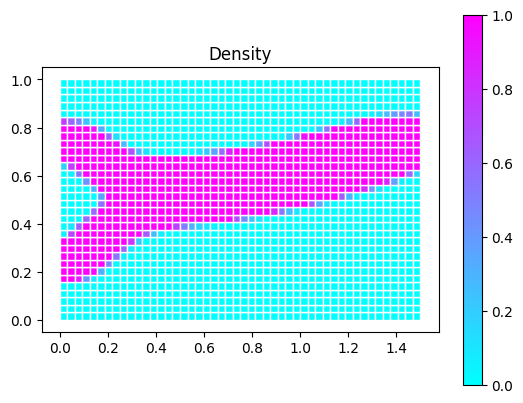

################ q = 1 #################
Iteration: 1, Objective Function: 0.006191775690396728, Volume Fraction: 0.3333428388471886
Iteration: 2, Objective Function: 0.006015224159161595, Volume Fraction: 0.33333865449389916
Iteration: 3, Objective Function: 0.005923700011829025, Volume Fraction: 0.33333365301890616
Iteration: 4, Objective Function: 0.005860757780159797, Volume Fraction: 0.33333413211824386
Iteration: 5, Objective Function: 0.0058374426736784585, Volume Fraction: 0.33333628378874997


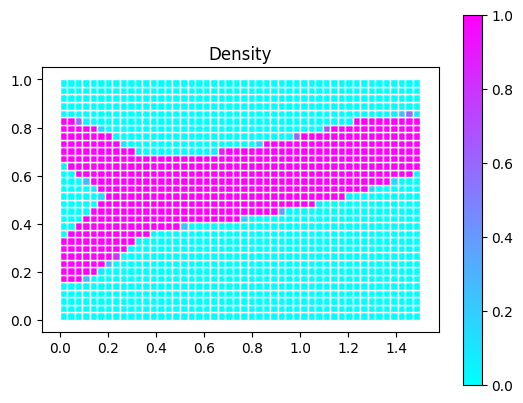

Iteration: 6, Objective Function: 0.005824133078707848, Volume Fraction: 0.3333309856933006
Iteration: 7, Objective Function: 0.005812974622527759, Volume Fraction: 0.33333344734328385
Iteration: 8, Objective Function: 0.005804575124892189, Volume Fraction: 0.3333334393165712
Iteration: 9, Objective Function: 0.005797075276272867, Volume Fraction: 0.3333323855372872
Iteration: 10, Objective Function: 0.005790122667703746, Volume Fraction: 0.33333266061005007


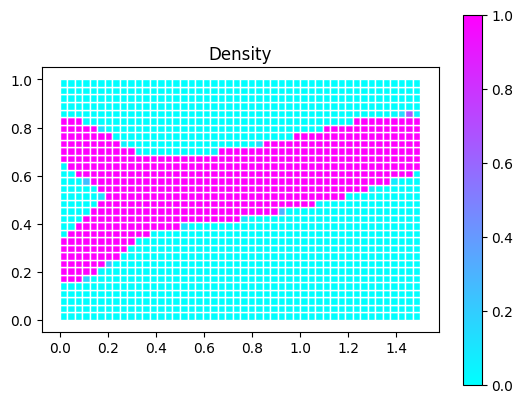

Iteration: 11, Objective Function: 0.005789465784277288, Volume Fraction: 0.33333335971162387
Iteration: 12, Objective Function: 0.005788813796394185, Volume Fraction: 0.33333238332002585
Iteration: 13, Objective Function: 0.005788205469116027, Volume Fraction: 0.33333216875564187
Iteration: 14, Objective Function: 0.005787505843785605, Volume Fraction: 0.33333432283605174
Iteration: 15, Objective Function: 0.005786566344352823, Volume Fraction: 0.3333324452563398


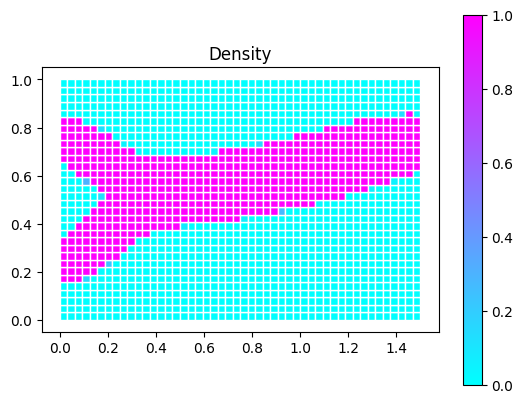

Iteration: 16, Objective Function: 0.005785769249594265, Volume Fraction: 0.33333364610038546
Iteration: 17, Objective Function: 0.0057855283231273745, Volume Fraction: 0.33333384665672156
Iteration: 18, Objective Function: 0.005785328717652533, Volume Fraction: 0.33333301405430554
Iteration: 19, Objective Function: 0.005785169404211245, Volume Fraction: 0.3333333660469195
Iteration: 20, Objective Function: 0.0057849707362509694, Volume Fraction: 0.3333328735331207


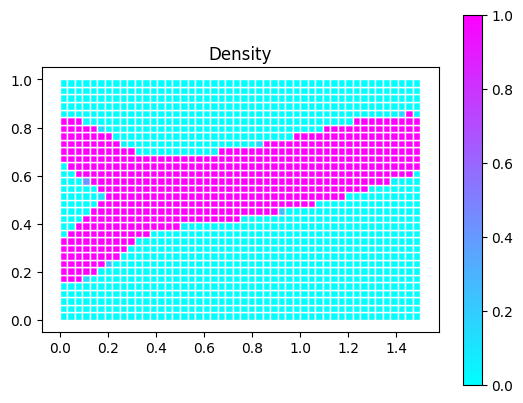

Iteration: 21, Objective Function: 0.00578480005245944, Volume Fraction: 0.3333339183599275
Iteration: 22, Objective Function: 0.005784569883939431, Volume Fraction: 0.3333326011730582
Iteration: 23, Objective Function: 0.005784412727761097, Volume Fraction: 0.33333369983340494
Iteration: 24, Objective Function: 0.005784152305662595, Volume Fraction: 0.33333386654111735
Iteration: 25, Objective Function: 0.00578389716963267, Volume Fraction: 0.3333343375395274


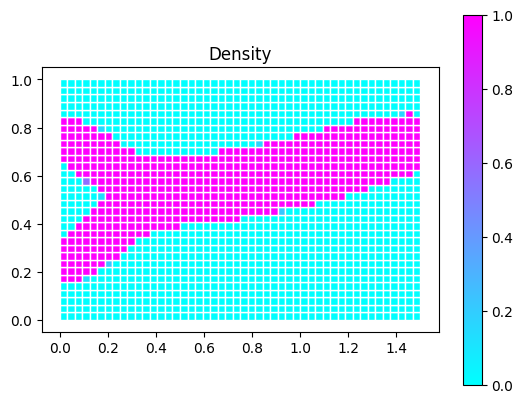

Iteration: 26, Objective Function: 0.005783587275703396, Volume Fraction: 0.3333328965862407
Iteration: 27, Objective Function: 0.005783279146572835, Volume Fraction: 0.3333324518056204
Iteration: 28, Objective Function: 0.005782822433831546, Volume Fraction: 0.3333338899001495
Iteration: 29, Objective Function: 0.0057820960605685316, Volume Fraction: 0.33333422120833395
Iteration: 30, Objective Function: 0.005781041109663853, Volume Fraction: 0.33333282465509734


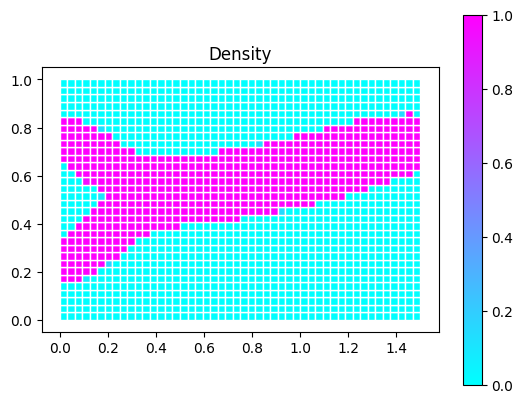

Iteration: 31, Objective Function: 0.005779297966238407, Volume Fraction: 0.3333334568401172
Iteration: 32, Objective Function: 0.005778009650894824, Volume Fraction: 0.3333332825637734


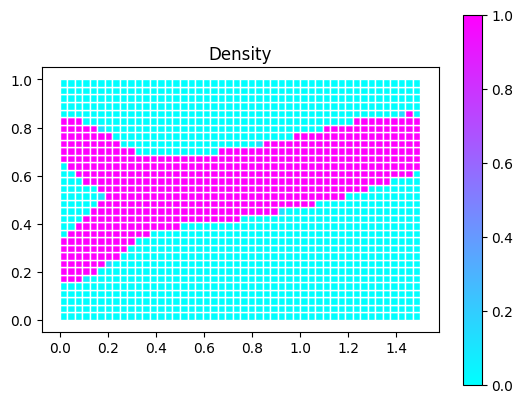

Final objective function (binary design): 0.005800455313224956, volume fraction 0.3326822916666667


In [11]:
poly_top = PolyTop(fem)
if active['classic']:
    density = poly_top.optimize(density_initial, density_min, density_max, volume_fraction_max,
                    design_tolerance, max_iterations, q_values,
                    opt_OCMove, opt_OCEta)
    
    binary_array = np.where(density >= 0.95, 1, 0)
    E = fem.viscosity/fem.epsilon*(1-binary_array)
    _, u, v, _, _, f = fem.solve(E)
    print(f'Final objective function (binary design): {f}, volume fraction {sum(binary_array)/mesh_p.area}')

### Optimization with Ising Machine Formulation

In [12]:
# Annealing Solver.
client = FixstarsClient()
client.parameters.timeout = 10000
client.parameters.outputs.duplicate = True
if os.path.exists('token_Fixstars.txt'):
    client.token = open('token_Fixstars.txt',"r").read().replace('\n', '')
if os.path.exists('proxy.txt'):
    client.proxy = open('proxy.txt',"r").read().replace('\n', '')

annealing_solver = AnnealingSolver(client)

In [13]:
# Topology Optimization Problem in Ising Machine Formulation.
n_qubits_per_variable = 9

hyperparameters = {
        'energy_dissipation': 1.,
        'regularization': 2.,
        'volume_constraint': 25.,
        'char_func': 50.
}

topo_opt_problem = TopologyOptimizationProblem(fem.ne, n_qubits_per_variable, hyperparameters, volume_fraction_max)
topo_opt_problem.generate_discretizaton()

Iteration: 0, Objective Function: 0.13446741351060815, Volume Fraction: 0.3333333333333333, Inconsistencies: 0
Max. change: 1.0
Iteration: 1, Objective Function: 0.13303389216384603, Volume Fraction: 0.3333333333333333, Inconsistencies: 0
Max. change: 1.0
Iteration: 2, Objective Function: 0.1319204748315902, Volume Fraction: 0.3333333333333333, Inconsistencies: 0
Max. change: 1.0
Iteration: 3, Objective Function: 0.13219936830122359, Volume Fraction: 0.3333333333333333, Inconsistencies: 0
Max. change: 1.0
Iteration: 4, Objective Function: 0.13510132889900867, Volume Fraction: 0.3333333333333333, Inconsistencies: 0
Max. change: 1.0
Iteration: 5, Objective Function: 0.13957265531277702, Volume Fraction: 0.3333333333333333, Inconsistencies: 0
Max. change: 0.8888888888888888
Iteration: 6, Objective Function: 0.14059637485784074, Volume Fraction: 0.3333333333333333, Inconsistencies: 0
Max. change: 1.0
Iteration: 7, Objective Function: 0.13648208279851654, Volume Fraction: 0.3333333333333333

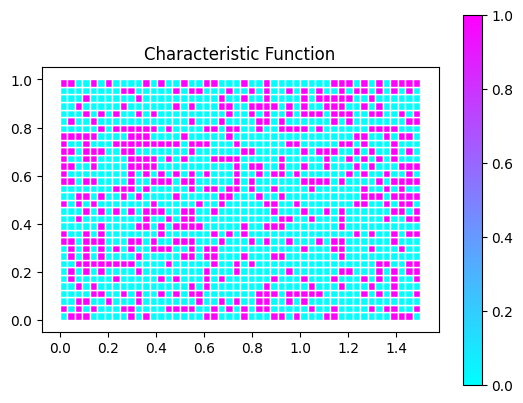

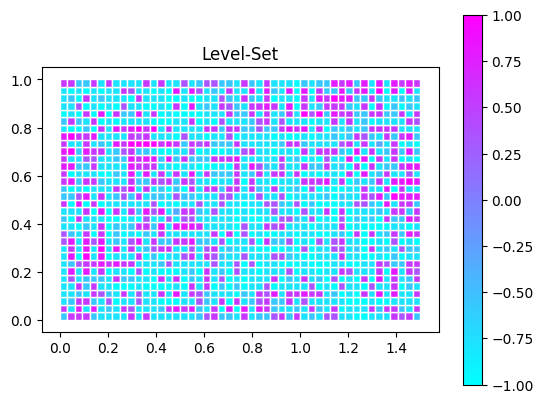

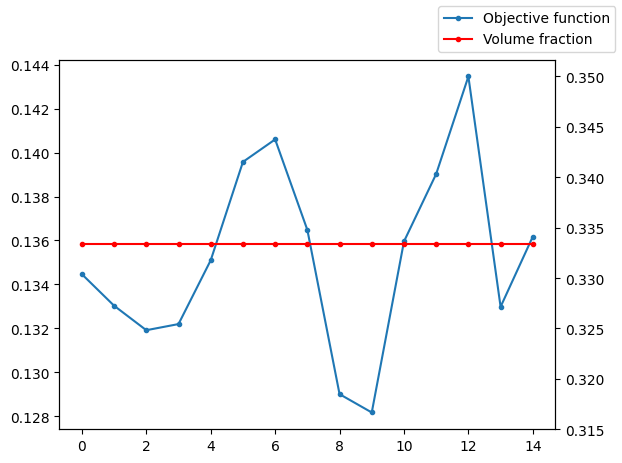

In [14]:
# Optimization
max_opt_steps = 15
# Initial scaled level-set values, i.e., design variables, for each element.
level_set_scaled_initial = np.ones(mesh_v.n_elem) 
annealing_optimizer = Annealing(fem)
if active['annealing']:
    annealing_optimizer.optimize(annealing_solver,
                                topo_opt_problem, 
                                level_set_scaled_initial,
                                max_opt_steps,
                                design_tolerance)
    annealing_optimizer.plot_history()